In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import os
import numpy as np
import pandas as pd
from collections import Counter

def pad_and_flatten_features(features, max_len=None):
    """
    features: list of np.array, each shape like (T_i, 17, 3)
    max_len: int or None, padding後的最大時間軸長度，None代表用目前最大長度
    """

    # 找最大長度 (若沒指定)
    if max_len is None:
        max_len = max(f.shape[0] for f in features)

    padded_features = []
    for f in features:
        T, J, C = f.shape
        if T < max_len:
            # pad zeros 到 max_len
            pad_width = ((0, max_len - T), (0, 0), (0, 0))
            f_padded = np.pad(f, pad_width=pad_width, mode='constant', constant_values=0)
        else:
            f_padded = f[:max_len]  # 如果長度超過 max_len，截斷

        # flatten 成 1維向量
        f_flat = f_padded.flatten()
        padded_features.append(f_flat)

    return np.array(padded_features)

def build_feature_label_dataframe(npy_folder, csv_path):
    # 讀取描述的 CSV
    df_csv = pd.read_csv(csv_path)

    data = []

    # 遍歷每個 .npy 檔案
    for file in os.listdir(npy_folder):
        if file.endswith('.npy'):
            base_name = os.path.splitext(file)[0]  # 去掉 .npy
            video_filename = base_name + '.mp4'    # 在 CSV 中查找

            # 找出對應的 label
            match = df_csv[df_csv['Filename'] == video_filename]

            if not match.empty:
                label = match.iloc[0]['description']
                feature_path = os.path.join(npy_folder, file)
                feature = np.load(feature_path)

                data.append({
                    'filename': file,
                    'feature': feature,
                    'label': label
                })
            else:
                print(f"⚠️ 無法在 CSV 中找到 {video_filename}")

    # 組成 DataFrame
    df = pd.DataFrame(data)
    return df

def convert_feature_to_dict(feature_array):
    n_frames = feature_array.shape[0]
    pose_sequence = []
    for frame_idx in range(len(feature_array)):
        pose_sequence.append({
            "frame":frame_idx,
            "keypoints":feature_array[frame_idx]
        })
    return pose_sequence

df = build_feature_label_dataframe('/content/drive/MyDrive/Baseball Movies/Gerrit_Cole_SL_videos_4S/npy','/content/drive/MyDrive/Baseball Movies/data_csv/Gerrit_Cole_SL.csv')
df['label'] = df['label'].str.contains('strike', case=False).astype(int)
df

,filename,feature,label
0,pitch_0001.npy,"[[[691.1320190429688, 235.2571563720703, 2.0],...",0
1,pitch_0004.npy,"[[[587.7108764648438, 172.42237854003906, 2.0]...",0
2,pitch_0002.npy,"[[[813.0626220703125, 451.5915222167969, 2.0],...",1
3,pitch_0003.npy,"[[[598.640625, 222.2551727294922, 2.0], [678.2...",1
4,pitch_0005.npy,"[[[414.9808044433594, 319.226318359375, 2.0], ...",1
...,...,...,...
195,pitch_0196.npy,"[[[789.1077270507812, 342.8899841308594, 2.0],...",0
196,pitch_0197.npy,"[[[483.5071105957031, 309.3092346191406, 2.0],...",1
197,pitch_0198.npy,"[[[744.2942504882812, 264.4396667480469, 2.0],...",0
198,pitch_0199.npy,"[[[486.62567138671875, 323.85498046875, 2.0], ...",0


✅ pose_simclr.py 完整檔案

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ---------- Pose Preprocessor ----------

class PosePreprocessor:
    def __init__(self, target_frames=240):
        self.target_frames = target_frames

    def normalize_skeleton(self, pose):
        pelvis = (pose[:, 11] + pose[:, 12]) / 2
        pose = pose - pelvis[:, None, :]
        ref_length = np.linalg.norm(pose[:, 0] - pose[:, 15], axis=1)
        ref_length = ref_length[:, None, None] + 1e-6
        pose = pose / ref_length
        return pose

    def temporal_crop_or_pad(self, pose):
        T = pose.shape[0]
        if T > self.target_frames:
            start = np.random.randint(0, T - self.target_frames)
            pose = pose[start:start + self.target_frames]
        elif T < self.target_frames:
            pad = np.zeros((self.target_frames - T, 17, 3))
            pose = np.concatenate([pose, pad], axis=0)
        return pose

    def __call__(self, pose):
        pose = self.normalize_skeleton(pose)
        pose = self.temporal_crop_or_pad(pose)
        return pose

# ---------- SimCLR Augmentation ----------

class PoseSimCLRAugmentation:
    def __init__(self, noise_std=0.01, flip_prob=0.5):
        self.noise_std = noise_std
        self.flip_prob = flip_prob

    def _augment(self, pose):
        noise = np.random.normal(0, self.noise_std, pose.shape)
        pose = pose + noise
        if np.random.rand() < self.flip_prob:
            pose[..., 0] *= -1
        return pose

    def __call__(self, pose):
        return self._augment(pose), self._augment(pose)

# ---------- Datasets ----------

class SimCLRDataset(Dataset):
    def __init__(self, df, preprocess, augmentation):
        self.df = df
        self.preprocess = preprocess
        self.augmentation = augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pose = self.preprocess(self.df.iloc[idx]['feature'])
        aug1, aug2 = self.augmentation(pose)
        return torch.tensor(aug1).float(), torch.tensor(aug2).float()

class ClassificationDataset(Dataset):
    def __init__(self, df, preprocess):
        self.df = df
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pose = self.preprocess(self.df.iloc[idx]['feature'])
        label = self.df.iloc[idx]['label']
        return torch.tensor(pose).float(), torch.tensor(label).long()

# ---------- Encoder ----------

class PoseEncoder(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, proj_size=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(17 * input_size, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, hidden_size),
            nn.ReLU()
        )
        self.projector = nn.Linear(hidden_size, proj_size)  # 只線性，不加ReLU

    def forward(self, x, return_proj=True):
        x = x.permute(0, 2, 1, 3)  # [B, 3, T, 17]
        x = x.reshape(x.size(0), -1, x.size(2))  # [B, 3*17, T]
        feat = self.encoder(x)  # [B, hidden]
        if return_proj:
            z = self.projector(feat)  # [B, proj]
            return F.normalize(z, dim=1)
        else:
            return feat  # 用於分類器輸入

# ---------- SimCLR Loss ----------

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5, device='cuda'):
        super().__init__()
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def _get_correlated_mask(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask.fill_diagonal_(False)
        for i in range(batch_size):
            mask[i, i + batch_size] = False
            mask[i + batch_size, i] = False
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size
        z = torch.cat([z_i, z_j], dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)
        positives = torch.cat([sim_i_j, sim_j_i], dim=0)

        mask = self._get_correlated_mask(batch_size).to(self.device)
        negatives = sim[mask].view(N, -1)

        labels = torch.zeros(N).to(self.device).long()
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        return loss



# ---------- Training ----------

def train_simclr(encoder, loader, epochs=20, device='cuda'):
    encoder = encoder.to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    criterion = NTXentLoss()
    for epoch in range(epochs):
        encoder.train()
        total_loss = 0
        for x1, x2 in tqdm(loader, desc=f"SimCLR Epoch {epoch+1}"):
            x1, x2 = x1.to(device), x2.to(device)
            z1 = encoder(x1,return_proj=True)
            z2 = encoder(x2,return_proj=True)
            loss = criterion(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

def train_classifier(encoder, loader, val_loader=None, epochs=10, device='cuda'):
    encoder = encoder.to(device)
    encoder.eval()  # freeze
    classifier = nn.Linear(128, 2).to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

    # 計算類別權重
    label_counts = Counter(train_df['label'])
    total = sum(label_counts.values())
    class_weights = [total / label_counts[i] for i in range(len(label_counts))]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    train_accs, val_accs = [], []

    for epoch in range(epochs):
        classifier.train()
        all_preds, all_labels = [], []
        for x, y in tqdm(loader, desc=f"Classifier Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                feat = encoder(x,return_proj=False)
            out = classifier(feat)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        train_accs.append(acc)
        print(f"Epoch {epoch+1} Train Acc: {acc:.4f}")

        if val_loader:
            classifier.eval()
            val_preds, val_labels = [], []
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                with torch.no_grad():
                    feat = encoder(x,return_proj=False)
                    out = classifier(feat)
                    preds = out.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y.cpu().numpy())
            val_acc = accuracy_score(val_labels, val_preds)
            val_accs.append(val_acc)
            print(f"Epoch {epoch+1} Val Acc: {val_acc:.4f}")

    # Plot accuracy
    plt.plot(train_accs, label='Train Acc')
    if val_loader:
        plt.plot(val_accs, label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Classification Accuracy")
    plt.show()

    # Classification report
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


✅ 使用範例 (訓練流程)

SimCLR Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 24.34it/s]


Epoch 1 Loss: 3.9999


SimCLR Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 25.47it/s]


Epoch 2 Loss: 3.4324


SimCLR Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 25.67it/s]


Epoch 3 Loss: 3.2479


SimCLR Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 24.66it/s]


Epoch 4 Loss: 3.1852


SimCLR Epoch 5: 100%|██████████| 6/6 [00:00<00:00, 26.05it/s]


Epoch 5 Loss: 3.1599


SimCLR Epoch 6: 100%|██████████| 6/6 [00:00<00:00, 23.88it/s]


Epoch 6 Loss: 3.1469


SimCLR Epoch 7: 100%|██████████| 6/6 [00:00<00:00, 25.55it/s]


Epoch 7 Loss: 3.0954


SimCLR Epoch 8: 100%|██████████| 6/6 [00:00<00:00, 24.64it/s]


Epoch 8 Loss: 3.0645


SimCLR Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 25.46it/s]


Epoch 9 Loss: 3.1050


SimCLR Epoch 10: 100%|██████████| 6/6 [00:00<00:00, 25.75it/s]


Epoch 10 Loss: 3.0727


SimCLR Epoch 11: 100%|██████████| 6/6 [00:00<00:00, 25.97it/s]


Epoch 11 Loss: 3.0861


SimCLR Epoch 12: 100%|██████████| 6/6 [00:00<00:00, 25.96it/s]


Epoch 12 Loss: 3.0752


SimCLR Epoch 13: 100%|██████████| 6/6 [00:00<00:00, 24.46it/s]


Epoch 13 Loss: 3.0816


SimCLR Epoch 14: 100%|██████████| 6/6 [00:00<00:00, 26.46it/s]


Epoch 14 Loss: 3.0230


SimCLR Epoch 15: 100%|██████████| 6/6 [00:00<00:00, 25.66it/s]


Epoch 15 Loss: 3.0403


SimCLR Epoch 16: 100%|██████████| 6/6 [00:00<00:00, 25.98it/s]


Epoch 16 Loss: 3.0498


SimCLR Epoch 17: 100%|██████████| 6/6 [00:00<00:00, 25.09it/s]


Epoch 17 Loss: 3.0255


SimCLR Epoch 18: 100%|██████████| 6/6 [00:00<00:00, 25.03it/s]


Epoch 18 Loss: 2.9536


SimCLR Epoch 19: 100%|██████████| 6/6 [00:00<00:00, 25.60it/s]


Epoch 19 Loss: 3.0069


SimCLR Epoch 20: 100%|██████████| 6/6 [00:00<00:00, 26.11it/s]


Epoch 20 Loss: 2.9961


SimCLR Epoch 21: 100%|██████████| 6/6 [00:00<00:00, 25.40it/s]


Epoch 21 Loss: 2.9251


SimCLR Epoch 22: 100%|██████████| 6/6 [00:00<00:00, 25.65it/s]


Epoch 22 Loss: 2.9198


SimCLR Epoch 23: 100%|██████████| 6/6 [00:00<00:00, 25.86it/s]


Epoch 23 Loss: 2.8747


SimCLR Epoch 24: 100%|██████████| 6/6 [00:00<00:00, 17.32it/s]


Epoch 24 Loss: 2.9007


SimCLR Epoch 25: 100%|██████████| 6/6 [00:00<00:00, 20.66it/s]


Epoch 25 Loss: 2.8324


SimCLR Epoch 26: 100%|██████████| 6/6 [00:00<00:00, 26.54it/s]


Epoch 26 Loss: 2.8251


SimCLR Epoch 27: 100%|██████████| 6/6 [00:00<00:00, 25.75it/s]


Epoch 27 Loss: 2.8279


SimCLR Epoch 28: 100%|██████████| 6/6 [00:00<00:00, 25.55it/s]


Epoch 28 Loss: 2.7798


SimCLR Epoch 29: 100%|██████████| 6/6 [00:00<00:00, 24.61it/s]


Epoch 29 Loss: 2.7828


SimCLR Epoch 30: 100%|██████████| 6/6 [00:00<00:00, 19.21it/s]


Epoch 30 Loss: 2.7685


SimCLR Epoch 31: 100%|██████████| 6/6 [00:00<00:00, 17.42it/s]


Epoch 31 Loss: 2.7557


SimCLR Epoch 32: 100%|██████████| 6/6 [00:00<00:00, 17.82it/s]


Epoch 32 Loss: 2.7939


SimCLR Epoch 33: 100%|██████████| 6/6 [00:00<00:00, 18.28it/s]


Epoch 33 Loss: 2.7452


SimCLR Epoch 34: 100%|██████████| 6/6 [00:00<00:00, 17.87it/s]


Epoch 34 Loss: 2.7179


SimCLR Epoch 35: 100%|██████████| 6/6 [00:00<00:00, 18.18it/s]


Epoch 35 Loss: 2.7462


SimCLR Epoch 36: 100%|██████████| 6/6 [00:00<00:00, 16.75it/s]


Epoch 36 Loss: 2.7989


SimCLR Epoch 37: 100%|██████████| 6/6 [00:00<00:00, 17.22it/s]


Epoch 37 Loss: 2.6734


SimCLR Epoch 38: 100%|██████████| 6/6 [00:00<00:00, 16.74it/s]


Epoch 38 Loss: 2.7198


SimCLR Epoch 39: 100%|██████████| 6/6 [00:00<00:00, 18.57it/s]


Epoch 39 Loss: 2.6956


SimCLR Epoch 40: 100%|██████████| 6/6 [00:00<00:00, 25.99it/s]


Epoch 40 Loss: 2.6912


SimCLR Epoch 41: 100%|██████████| 6/6 [00:00<00:00, 24.94it/s]


Epoch 41 Loss: 2.6375


SimCLR Epoch 42: 100%|██████████| 6/6 [00:00<00:00, 25.09it/s]


Epoch 42 Loss: 2.6543


SimCLR Epoch 43: 100%|██████████| 6/6 [00:00<00:00, 25.03it/s]


Epoch 43 Loss: 2.6744


SimCLR Epoch 44: 100%|██████████| 6/6 [00:00<00:00, 23.99it/s]


Epoch 44 Loss: 2.6555


SimCLR Epoch 45: 100%|██████████| 6/6 [00:00<00:00, 25.89it/s]


Epoch 45 Loss: 2.6043


SimCLR Epoch 46: 100%|██████████| 6/6 [00:00<00:00, 25.59it/s]


Epoch 46 Loss: 2.6315


SimCLR Epoch 47: 100%|██████████| 6/6 [00:00<00:00, 25.02it/s]


Epoch 47 Loss: 2.6114


SimCLR Epoch 48: 100%|██████████| 6/6 [00:00<00:00, 25.88it/s]


Epoch 48 Loss: 2.5781


SimCLR Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 25.79it/s]


Epoch 49 Loss: 2.6040


SimCLR Epoch 50: 100%|██████████| 6/6 [00:00<00:00, 26.54it/s]


Epoch 50 Loss: 2.5999


SimCLR Epoch 51: 100%|██████████| 6/6 [00:00<00:00, 24.76it/s]


Epoch 51 Loss: 2.6020


SimCLR Epoch 52: 100%|██████████| 6/6 [00:00<00:00, 25.79it/s]


Epoch 52 Loss: 2.6230


SimCLR Epoch 53: 100%|██████████| 6/6 [00:00<00:00, 25.73it/s]


Epoch 53 Loss: 2.6167


SimCLR Epoch 54: 100%|██████████| 6/6 [00:00<00:00, 26.15it/s]


Epoch 54 Loss: 2.6438


SimCLR Epoch 55: 100%|██████████| 6/6 [00:00<00:00, 26.25it/s]


Epoch 55 Loss: 2.5728


SimCLR Epoch 56: 100%|██████████| 6/6 [00:00<00:00, 24.26it/s]


Epoch 56 Loss: 2.5958


SimCLR Epoch 57: 100%|██████████| 6/6 [00:00<00:00, 26.36it/s]


Epoch 57 Loss: 2.5808


SimCLR Epoch 58: 100%|██████████| 6/6 [00:00<00:00, 26.25it/s]


Epoch 58 Loss: 2.5993


SimCLR Epoch 59: 100%|██████████| 6/6 [00:00<00:00, 25.69it/s]


Epoch 59 Loss: 2.6138


SimCLR Epoch 60: 100%|██████████| 6/6 [00:00<00:00, 24.45it/s]


Epoch 60 Loss: 2.6241


SimCLR Epoch 61: 100%|██████████| 6/6 [00:00<00:00, 25.81it/s]


Epoch 61 Loss: 2.6047


SimCLR Epoch 62: 100%|██████████| 6/6 [00:00<00:00, 25.84it/s]


Epoch 62 Loss: 2.5708


SimCLR Epoch 63: 100%|██████████| 6/6 [00:00<00:00, 24.77it/s]


Epoch 63 Loss: 2.6049


SimCLR Epoch 64: 100%|██████████| 6/6 [00:00<00:00, 24.18it/s]


Epoch 64 Loss: 2.5473


SimCLR Epoch 65: 100%|██████████| 6/6 [00:00<00:00, 26.12it/s]


Epoch 65 Loss: 2.5807


SimCLR Epoch 66: 100%|██████████| 6/6 [00:00<00:00, 25.82it/s]


Epoch 66 Loss: 2.6021


SimCLR Epoch 67: 100%|██████████| 6/6 [00:00<00:00, 25.56it/s]


Epoch 67 Loss: 2.5938


SimCLR Epoch 68: 100%|██████████| 6/6 [00:00<00:00, 26.30it/s]


Epoch 68 Loss: 2.6069


SimCLR Epoch 69: 100%|██████████| 6/6 [00:00<00:00, 23.92it/s]


Epoch 69 Loss: 2.5803


SimCLR Epoch 70: 100%|██████████| 6/6 [00:00<00:00, 25.59it/s]


Epoch 70 Loss: 2.5981


SimCLR Epoch 71: 100%|██████████| 6/6 [00:00<00:00, 25.83it/s]


Epoch 71 Loss: 2.5728


SimCLR Epoch 72: 100%|██████████| 6/6 [00:00<00:00, 26.00it/s]


Epoch 72 Loss: 2.5619


SimCLR Epoch 73: 100%|██████████| 6/6 [00:00<00:00, 24.19it/s]


Epoch 73 Loss: 2.5697


SimCLR Epoch 74: 100%|██████████| 6/6 [00:00<00:00, 25.47it/s]


Epoch 74 Loss: 2.5852


SimCLR Epoch 75: 100%|██████████| 6/6 [00:00<00:00, 26.15it/s]


Epoch 75 Loss: 2.5487


SimCLR Epoch 76: 100%|██████████| 6/6 [00:00<00:00, 25.82it/s]


Epoch 76 Loss: 2.5604


SimCLR Epoch 77: 100%|██████████| 6/6 [00:00<00:00, 24.43it/s]


Epoch 77 Loss: 2.6025


SimCLR Epoch 78: 100%|██████████| 6/6 [00:00<00:00, 25.34it/s]


Epoch 78 Loss: 2.6237


SimCLR Epoch 79: 100%|██████████| 6/6 [00:00<00:00, 26.36it/s]


Epoch 79 Loss: 2.5658


SimCLR Epoch 80: 100%|██████████| 6/6 [00:00<00:00, 26.04it/s]


Epoch 80 Loss: 2.5260


SimCLR Epoch 81: 100%|██████████| 6/6 [00:00<00:00, 19.92it/s]


Epoch 81 Loss: 2.5382


SimCLR Epoch 82: 100%|██████████| 6/6 [00:00<00:00, 17.42it/s]


Epoch 82 Loss: 2.5494


SimCLR Epoch 83: 100%|██████████| 6/6 [00:00<00:00, 17.93it/s]


Epoch 83 Loss: 2.5446


SimCLR Epoch 84: 100%|██████████| 6/6 [00:00<00:00, 16.40it/s]


Epoch 84 Loss: 2.5507


SimCLR Epoch 85: 100%|██████████| 6/6 [00:00<00:00, 16.96it/s]


Epoch 85 Loss: 2.5536


SimCLR Epoch 86: 100%|██████████| 6/6 [00:00<00:00, 17.91it/s]


Epoch 86 Loss: 2.5387


SimCLR Epoch 87: 100%|██████████| 6/6 [00:00<00:00, 17.50it/s]


Epoch 87 Loss: 2.5323


SimCLR Epoch 88: 100%|██████████| 6/6 [00:00<00:00, 16.42it/s]


Epoch 88 Loss: 2.5296


SimCLR Epoch 89: 100%|██████████| 6/6 [00:00<00:00, 16.36it/s]


Epoch 89 Loss: 2.5596


SimCLR Epoch 90: 100%|██████████| 6/6 [00:00<00:00, 17.56it/s]


Epoch 90 Loss: 2.5211


SimCLR Epoch 91: 100%|██████████| 6/6 [00:00<00:00, 24.75it/s]


Epoch 91 Loss: 2.5237


SimCLR Epoch 92: 100%|██████████| 6/6 [00:00<00:00, 25.63it/s]


Epoch 92 Loss: 2.5327


SimCLR Epoch 93: 100%|██████████| 6/6 [00:00<00:00, 26.15it/s]


Epoch 93 Loss: 2.5660


SimCLR Epoch 94: 100%|██████████| 6/6 [00:00<00:00, 25.75it/s]


Epoch 94 Loss: 2.5492


SimCLR Epoch 95: 100%|██████████| 6/6 [00:00<00:00, 24.64it/s]


Epoch 95 Loss: 2.5447


SimCLR Epoch 96: 100%|██████████| 6/6 [00:00<00:00, 26.07it/s]


Epoch 96 Loss: 2.5571


SimCLR Epoch 97: 100%|██████████| 6/6 [00:00<00:00, 25.80it/s]


Epoch 97 Loss: 2.5590


SimCLR Epoch 98: 100%|██████████| 6/6 [00:00<00:00, 25.87it/s]


Epoch 98 Loss: 2.5579


SimCLR Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 24.62it/s]


Epoch 99 Loss: 2.5322


SimCLR Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 25.63it/s]


Epoch 100 Loss: 2.5133


Classifier Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 90.28it/s]


Epoch 1 Train Acc: 0.4409
Epoch 1 Val Acc: 0.3000


Classifier Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 83.99it/s]


Epoch 2 Train Acc: 0.4636
Epoch 2 Val Acc: 0.3000


Classifier Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 89.83it/s]


Epoch 3 Train Acc: 0.5227
Epoch 3 Val Acc: 0.3250


Classifier Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 87.89it/s]


Epoch 4 Train Acc: 0.5182
Epoch 4 Val Acc: 0.3500


Classifier Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 92.47it/s]


Epoch 5 Train Acc: 0.4727
Epoch 5 Val Acc: 0.4000


Classifier Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 89.38it/s]


Epoch 6 Train Acc: 0.5409
Epoch 6 Val Acc: 0.4500


Classifier Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 93.60it/s]


Epoch 7 Train Acc: 0.5636
Epoch 7 Val Acc: 0.4750


Classifier Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 79.94it/s]

Epoch 8 Train Acc: 0.5591


Epoch 8 Val Acc: 0.4750


Classifier Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 90.35it/s]

Epoch 9 Train Acc: 0.5182


Epoch 9 Val Acc: 0.3500


Classifier Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 89.93it/s]


Epoch 10 Train Acc: 0.5227
Epoch 10 Val Acc: 0.3250


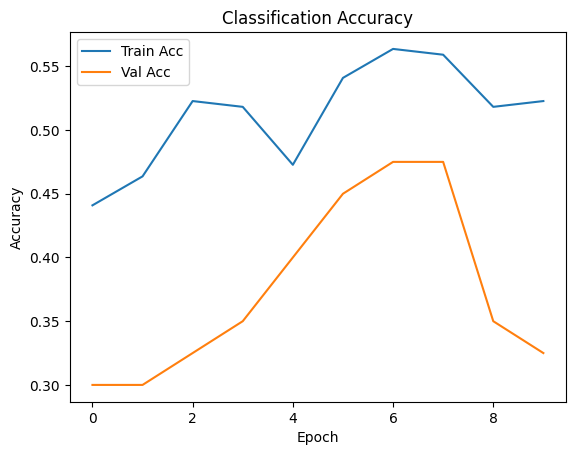

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.16      0.23       101
           1       0.54      0.83      0.65       119

    accuracy                           0.52       220
   macro avg       0.49      0.50      0.44       220
weighted avg       0.50      0.52      0.46       220



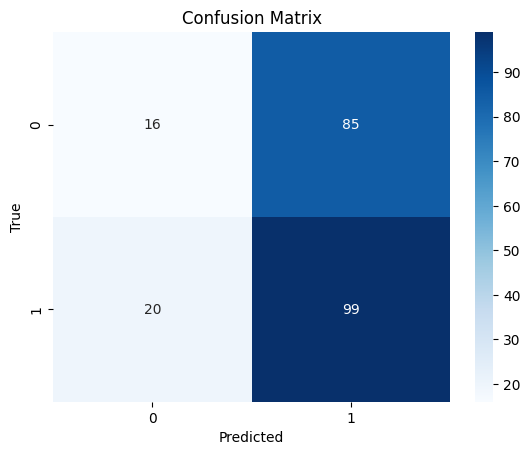

In [138]:
from sklearn.model_selection import train_test_split

# 假設 df 裡有 'feature' (ndarray) 與 'label'
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])

# ✅ 方案三：過採樣（OverSampling）或欠採樣（UnderSampling）
from sklearn.utils import resample
df_majority = train_df[train_df['label'] == 0]
df_minority = train_df[train_df['label'] == 1]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=len(df_majority),random_state=42)
train_df_balanced = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df_balanced

preprocess = PosePreprocessor(target_frames=240)
augment = PoseSimCLRAugmentation()

# SimCLR pretrain
simclr_dataset = SimCLRDataset(train_df, preprocess, augment)
simclr_loader = DataLoader(simclr_dataset, batch_size=32, shuffle=True, drop_last=True)

encoder = PoseEncoder()
train_simclr(encoder, simclr_loader, epochs=100)

# Linear classifier
clf_train = ClassificationDataset(train_df, preprocess)
clf_val = ClassificationDataset(val_df, preprocess)

# 使用 WeightedRandomSampler 讓 DataLoader 平衡取樣
from torch.utils.data import WeightedRandomSampler
# 計算每個樣本的 weight
labels = train_df['label'].values
class_sample_count = np.array([np.sum(labels == t) for t in np.unique(labels)])
weights = 1. / class_sample_count
sample_weights = np.array([weights[t] for t in labels])
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(clf_train, batch_size=32,sampler=sampler)

val_loader = DataLoader(clf_val, batch_size=32)
train_classifier(encoder, train_loader, val_loader, epochs=10)
